In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [5]:
# Data Loading

ecg1, ppg1 = np.load('data/first_ecg.npy'), np.load('data/first_ppg.npy')
ecg2, ppg2 = np.load('data/second_ecg.npy'), np.load('data/second_ppg.npy')
ecg3, ppg3 = np.load('data/third_ecg.npy'), np.load('data/third_ppg.npy')

### Task 1
The signals have been recorded with different sampling frequencies. Can you
tell them?

_Hint_: they were recorded from healthy subjects at rest.

The normal resting heart rate is known to be in range 60 to 100 bits per minute (bpm). We will use this rande to estimate the sample frequencies.

But firstly, let's visualize the data

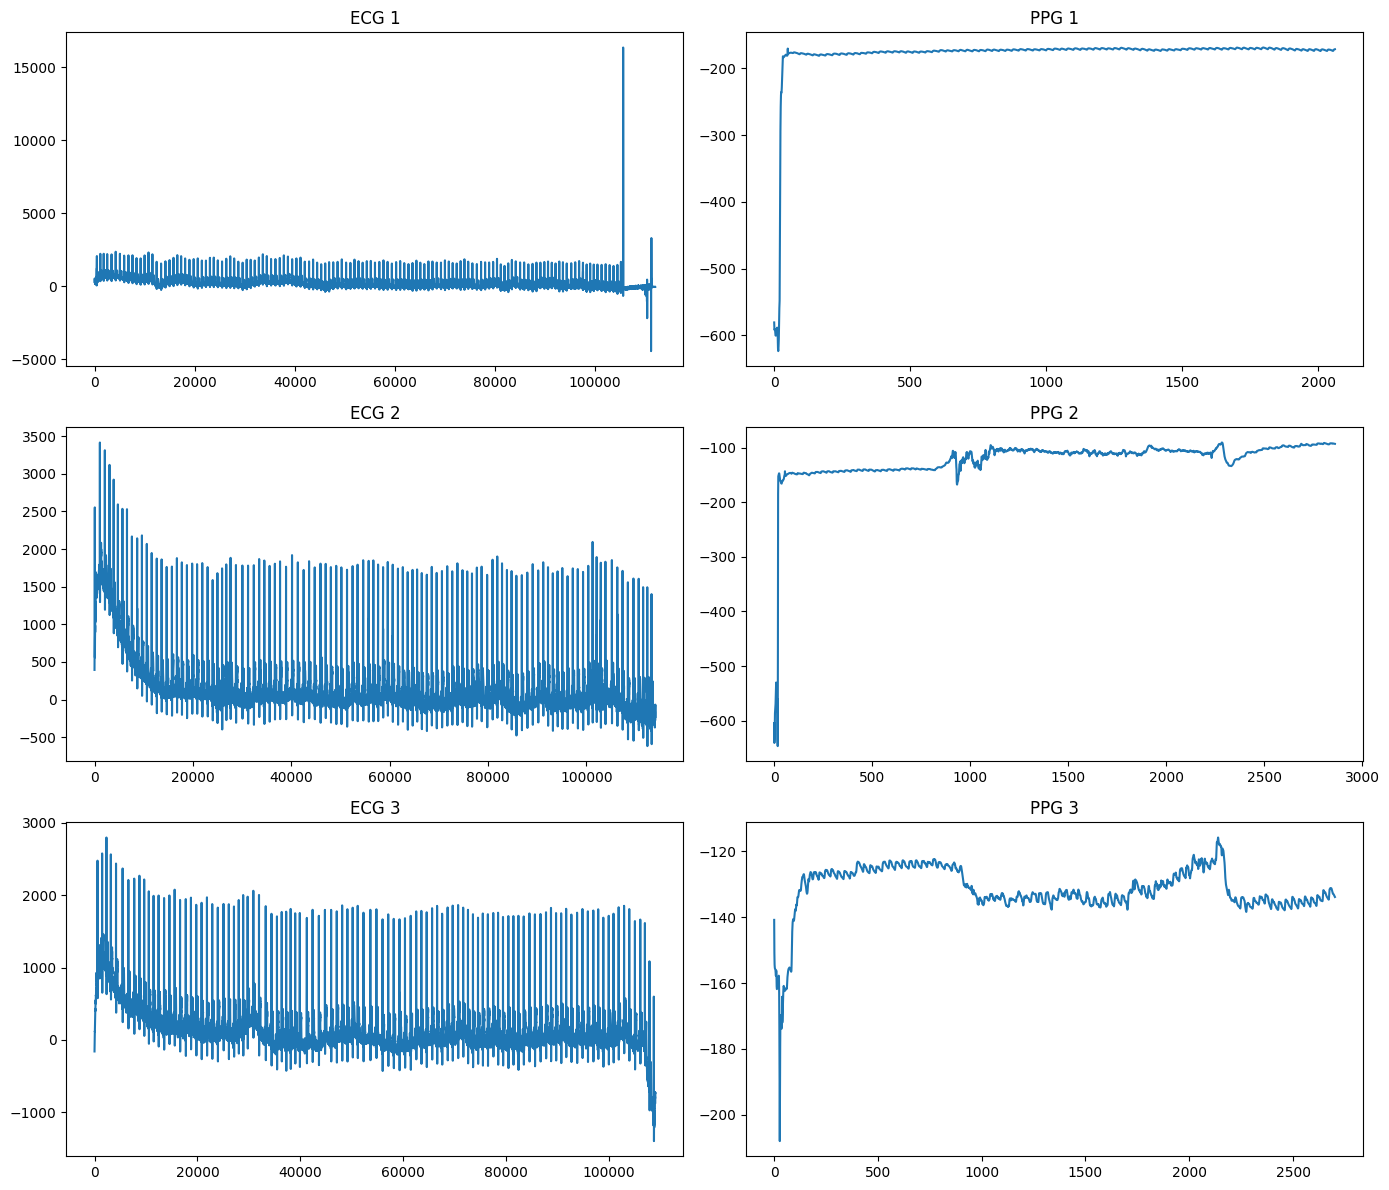

In [6]:
# Create the plots
fig, axs = plt.subplots(3, 2, figsize=(14, 12))

# Plot ECG and PPG for the first dataset
axs[0, 0].plot(ecg1)
axs[0, 0].set_title('ECG 1')
axs[0, 1].plot(ppg1)
axs[0, 1].set_title('PPG 1')

# Plot ECG and PPG for the second dataset
axs[1, 0].plot(ecg2)
axs[1, 0].set_title('ECG 2')
axs[1, 1].plot(ppg2)
axs[1, 1].set_title('PPG 2')

# Plot ECG and PPG for the third dataset
axs[2, 0].plot(ecg3)
axs[2, 0].set_title('ECG 3')
axs[2, 1].plot(ppg3)
axs[2, 1].set_title('PPG 3')

# Adjust layout for better readability
plt.tight_layout()
plt.show()

To estimate the frequency, we need to determine how many times the heart bited during the entire observation time. Sampling frequency will be estimated as follows:

$$\frac{number \; of \; heart \; bits}{sample \; size} = X bps$$

$$frequency = \frac{X \; bps \cdot sample \; size}{number \; of \; heart \; bits}$$

$Number \; of \; heart \; bits$ can be estimated as number of $R$ peaks

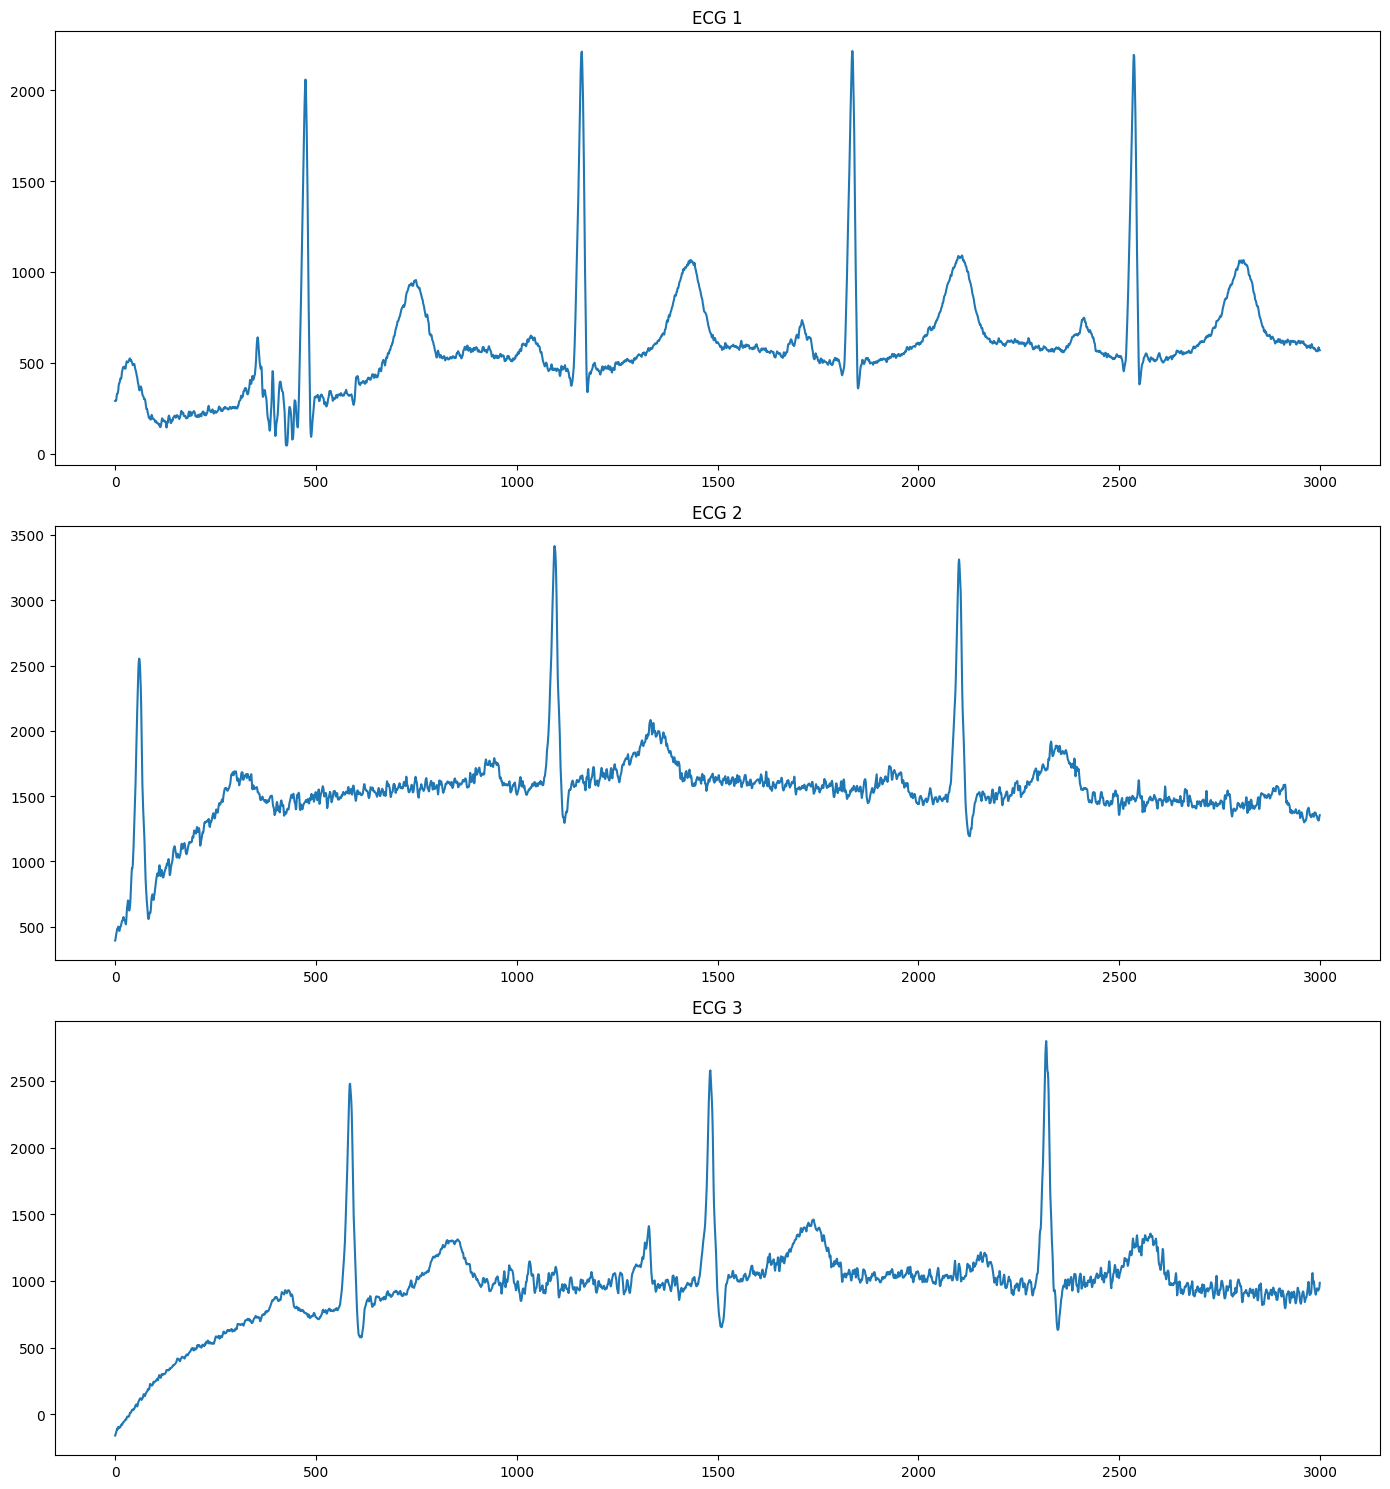

In [38]:
# Lokking deeply at the data -- let's see the ECG peaks

fig, axs = plt.subplots(3, 1, figsize=(14, 15))

# Plot ECG and PPG for the first dataset
axs[0].plot(ecg1[:3000])
axs[0].set_title('ECG 1')

# Plot ECG and PPG for the second dataset
axs[1].plot(ecg2[:3000])
axs[1].set_title('ECG 2')

# Plot ECG and PPG for the third dataset
axs[2].plot(ecg3[:3000])
axs[2].set_title('ECG 3')

# Adjust layout for better readability
plt.tight_layout()
plt.show()

In [25]:
# Function to detect R-peaks
def detect_r_peaks(ecg_signal, height=None, distance=None):
    peaks, _ = find_peaks(ecg_signal, height=height, distance=distance)
    return peaks

In [42]:
ecg1_peaks = detect_r_peaks(ecg1, distance=500)
ecg1_sample_freq = len(ecg1) / len(ecg1_peaks)
print(f'The first ECG sampling frequency is ~ {len(ecg1) / len(ecg1_peaks)}')


ecg2_peaks = detect_r_peaks(ecg2, distance=900)
print(f'The second ECG sampling frequency is ~ {len(ecg2) / len(ecg2_peaks)}')

ecg3_peaks = detect_r_peaks(ecg3, distance=900)
print(f'The third ECG sampling frequency is ~ {len(ecg3) / len(ecg3_peaks)}')


The first ECG sampling frequency is ~ 800.0
The second ECG sampling frequency is ~ 1065.4205607476636
The third ECG sampling frequency is ~ 1090.0
